In [40]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model

In [23]:
%matplotlib notebook
%widescreen

In [97]:
# Natural cubic spline fitting algorithm from: 
# https://github.com/madrury/basis-expansions/blob/master/basis_expansions/basis_expansions.py
from sklearn.base import BaseEstimator, TransformerMixin

class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""
    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None, knot_strategy='even'):
        self.knots = knots
        self.min, self.max = min, max
        self.knot_strategy = knot_strategy
        if knots is None:
            if n_knots is None:
               n_knots = self._compute_n_knots(n_params)
            self.n_knots = n_knots
        else:
            self.n_knots = len(knots)

    def fit(self, X, *args, **kwargs):
        if self.min is None:
            self.min = X.min()
        if self.max is None:
            self.max = X.max()
        if self.knots is None:
            if self.knot_strategy == 'even':
                self.knots = np.linspace(self.min, self.max, num=(self.n_knots + 2))[1:-1]
            elif self.knot_strategy == 'quantiles':
                quantiles = np.linspace(0.0, 1.0, num=(self.n_knots + 2))[1:-1]
                self.knots = np.quantile(X, quantiles)
        return self

class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.
    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float
        Minimum of interval containing the knots.
    max: float
        Maximum of the interval containing the knots.
    n_knots: positive integer
        The number of knots to create.
    knot_strategy: str
        Strategy for determining the knots at fit time. Current options are:
          - 'even': Evenly position the knots within the range (min, max).
          - 'quantiles': Set the knots to even quantiles of the data distribution.
    knots: array or list of floats
        The knots.
    """
    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        if isinstance(X, pd.DataFrame):
            assert X.shape[1] == 1
            X = X.iloc[:, 0]
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                     for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = np.asarray(X).reshape(-1)
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError:
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X

        def d(knot_idx, x):
            ppart = lambda t: np.maximum(0, t)
            cube = lambda t: t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                            - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X))
        return X_spl

In [8]:
def identify_wraps(row,lower_threshold=1.5,upper_threshold=3.5):
    
    if row['v_sig'] < lower_threshold and row['v_sig_last'] > upper_threshold:
        return 1 # positive wrap
    elif row['v_sig'] > upper_threshold and row['v_sig_last'] < lower_threshold:
        return -1 # negative wrap
    else:
        return 0

def calculate_wrap_corrected_diff(row, max_diff = 1, nan_transitions=False):
    if row['wrap_ID'] == 1:
        # unrwap the current value, subtract the last valueif nan_transitions:
        if nan_transitions:
            diff = np.nan
        else:
            diff = (row['v_sig'] + row['v_in']) - row['v_sig_last']
    elif row['wrap_ID'] == -1:
        # unwrap the last value, subtract it from the current value
        if nan_transitions:
            diff = np.nan
        else:
            diff = row['v_sig'] - (row['v_sig_last'] + row['v_in'])
    else:
        diff = row['v_sig'] - row['v_sig_last']
        
    if np.abs(diff) > max_diff:
        return row['v_sig_diff_rolling_median']
    else:
        return diff

In [16]:
def add_columns_and_unwrap(df):
    df['dv'] = df['v_sig'].diff()
    df['v_sig_last'] = df['v_sig'].shift()
    df['wrap_ID'] = df.apply(identify_wraps,axis=1)
    df['v_sig_diff'] = df.apply(calculate_wrap_corrected_diff,axis=1,nan_transitions=False)
    df['v_sig_unwrapped'] = np.cumsum(df['v_sig_diff']) + df['v_sig'].iloc[0]
    
    return df

In [315]:
def calculate_speed(df,voltage_column,time_column='time'):
    
    delta_theta = df[voltage_column].diff()/df['v_in']*2*np.pi # delta theta at each step in radians
    dt = df[time_column].diff() # deltaa time at each step
    
    wheel_diameter = 6.5 * 2.54  # 6.5" wheel diameter
    running_radius = 0.5 * (2.0 * wheel_diameter / 3.0)  # assume the animal runs at 2/3 the distance from the wheel center
    
    speed = delta_theta/dt * running_radius # linear speed in cm/s
    
    return speed
    

In [316]:
def calculate_derivative(df,column_to_differentiate,time_column='time'):
    dy = df[column_to_differentiate].diff() # delta at each step

    dt = df[time_column].diff().shift() # deltaa time at each step, shifted to realign
    dt = df[time_column].diff()# deltaa time at each step, shifted to realign
    
    derivative = dy/dt
    
    return derivative

In [310]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

def make_natural_cubic_regression(n_knots):
    return Pipeline([
        ('nat_cubic', NaturalCubicSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

In [311]:
def spline_regression(df, col_to_smooth, n_knots, time_column='time'):
    
    n_knots = int(n_knots)

    r = make_natural_cubic_regression(n_knots)
    t = df_sample[time_column].values.reshape(-1,1)
    t_norm = (t-t[0])/(t[-1]-t[0])
    y = df_sample[col_to_smooth].fillna(method='bfill').values
    
    r.fit(t_norm,y)
    
    return r.predict(t_norm)
    

In [431]:
df_sample = pd.read_csv('/home/dougo/2020.06.26_running_data_sample.csv')
df_sample

,time,v_sig,v_in
0,2920.006553,2.799827,4.987230
1,2920.023353,2.923862,4.984646
2,2920.040033,2.994923,4.976894
3,2920.056603,3.126710,4.982062
4,2920.073273,3.271417,4.989814
...,...,...,...
1194,2939.922813,4.454914,4.978186
1195,2939.939613,4.528560,4.989814
1196,2939.956263,4.671975,4.988522
1197,2939.972843,4.821850,4.989814


In [439]:
df_sample = add_columns_and_unwrap(df_sample)
df_sample['speed_raw'] = calculate_speed(df_sample, voltage_column='v_sig_unwrapped')
df_sample['acceleration_raw'] = calculate_derivative(df_sample, 'speed_raw')
df_sample['jerk_raw'] = calculate_derivative(df_sample, 'acceleration_raw')

n_knot_factors = [2,3,9,50]
for n_knot_factor in n_knot_factors:
    n_knots = len(df_sample)/n_knot_factor
    df_sample['v_spline_smoothed_F={}'.format(n_knot_factor)] = spline_regression(df_sample, col_to_smooth='v_sig_unwrapped', n_knots=n_knots)
    df_sample['speed_spline_smoothed_F={}'.format(n_knot_factor)] = calculate_speed(df_sample, voltage_column='v_spline_smoothed_F={}'.format(n_knot_factor))
    df_sample['acceleration_spline_smoothed_F={}'.format(n_knot_factor)] = calculate_derivative(df_sample, 'speed_spline_smoothed_F={}'.format(n_knot_factor))
    df_sample['jerk_spline_smoothed_F={}'.format(n_knot_factor)] = calculate_derivative(df_sample, 'acceleration_spline_smoothed_F={}'.format(n_knot_factor))

# df_sample['speed_spline_smoothed_direct'] = spline_regression(df_sample, col_to_smooth='speed_raw', n_knots=n_knots)

df_sample.head(100)

,time,v_sig,v_in,dv,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped,speed_raw,acceleration_raw,jerk_raw,v_spline_smoothed_F=2,speed_spline_smoothed_F=2,acceleration_spline_smoothed_F=2,jerk_spline_smoothed_F=2,v_spline_smoothed_F=3,speed_spline_smoothed_F=3,acceleration_spline_smoothed_F=3,jerk_spline_smoothed_F=3,v_spline_smoothed_F=9,speed_spline_smoothed_F=9,acceleration_spline_smoothed_F=9,jerk_spline_smoothed_F=9,v_spline_smoothed_F=20,speed_spline_smoothed_F=20,acceleration_spline_smoothed_F=20,jerk_spline_smoothed_F=20,v_spline_smoothed_F=50,speed_spline_smoothed_F=50,acceleration_spline_smoothed_F=50,jerk_spline_smoothed_F=50
0,2920.006553,2.799827,4.987230,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,2.881146,NaN,NaN,NaN,2.856943,NaN,NaN,NaN,2.800960,NaN,NaN,NaN,2.793656,NaN,NaN,NaN,2.797592,NaN,NaN,NaN
1,2920.023353,2.923862,4.984646,0.124035,2.799827,0,0.124035,2.923862,NaN,NaN,NaN,2.959936,32.533544,NaN,NaN,2.954903,40.449266,NaN,NaN,2.918667,48.603174,NaN,NaN,2.913872,49.639285,NaN,NaN,2.919376,50.286755,NaN,NaN
2,2920.040033,2.994923,4.976894,0.071062,2.923862,0,0.071062,2.994923,29.599596,NaN,NaN,3.038163,32.584221,3.038185,NaN,3.052163,40.512271,3.777281,NaN,3.035533,48.678879,4.538719,NaN,3.033230,49.716605,4.635474e+00,NaN,3.040291,50.365083,4.695937e+00,NaN
3,2920.056603,3.126710,4.982062,0.131787,2.994923,0,0.131787,3.126710,55.200887,1545.038693,NaN,3.119369,34.014343,86.307912,5025.330534,3.148782,40.470246,-2.536216,-381.019722,3.151629,48.628383,-3.047479,-457.827290,3.151800,49.665032,-3.112445e+00,-467.587151,3.160408,50.312837,-3.153042e+00,-473.686122
4,2920.073273,3.271417,4.989814,0.144707,3.126710,0,0.144707,3.271417,60.155532,297.219258,-74854.195297,3.221826,42.592293,514.574052,25690.830204,3.246798,40.745851,16.532980,1143.922980,3.268425,48.552834,-4.532032,-89.055334,3.271086,49.587872,-4.628645e+00,-90.953796,3.281250,50.234672,-4.689018e+00,-92.140152
5,2920.089963,3.333434,4.978186,0.062017,3.271417,0,0.062017,3.333434,25.810197,-2057.839168,-141105.957214,3.355920,55.806519,791.745123,16607.014451,3.349774,42.856311,126.450615,6585.837910,3.385361,48.666245,6.795188,678.683029,3.390515,49.703702,6.940046e+00,693.151044,3.402237,50.352012,7.030569e+00,702.192156
6,2920.106763,3.487186,4.989814,0.153751,3.333434,0,0.153751,3.487186,63.420671,2238.718700,255747.492158,3.493700,56.832984,61.099134,-43490.832664,3.463201,46.787393,233.992973,6401.330859,3.503068,48.552834,-6.750696,-806.302605,3.510732,49.587872,-6.894606e+00,-823.491186,3.524021,50.234672,-6.984535e+00,-834.232389
7,2920.123323,3.625433,4.979478,0.138247,3.487186,0,0.138247,3.625433,57.971849,-329.035108,-155057.597089,3.605793,47.004231,-593.523741,-39530.366849,3.587120,51.963650,312.575859,4745.343346,3.619094,48.653618,6.086004,775.163049,3.629231,49.690805,6.215744e+00,791.687804,3.644066,50.338947,6.296819e+00,802.014180
8,2920.140003,3.696494,4.991106,0.071062,3.625433,0,0.071062,3.696494,29.515310,-1706.027510,-82553.501351,3.712797,44.444229,-153.477360,26381.677501,3.717879,54.310374,140.690891,-10304.854244,3.735960,48.540265,-6.795738,-772.286714,3.748588,49.575036,-6.940608e+00,-788.750153,3.764980,50.221667,-7.031138e+00,-799.038211
9,2920.156683,3.834741,4.978186,0.138247,3.696494,0,0.138247,3.834741,57.569723,1681.919236,203114.313331,3.834672,50.751921,378.159036,31872.685616,3.846273,53.466710,-50.579373,-11467.042157,3.852826,48.666249,7.552970,860.234290,3.867946,49.703702,7.713788e+00,878.560932,3.885894,50.352012,7.814403e+00,890.020437


<IPython.core.display.Javascript object>


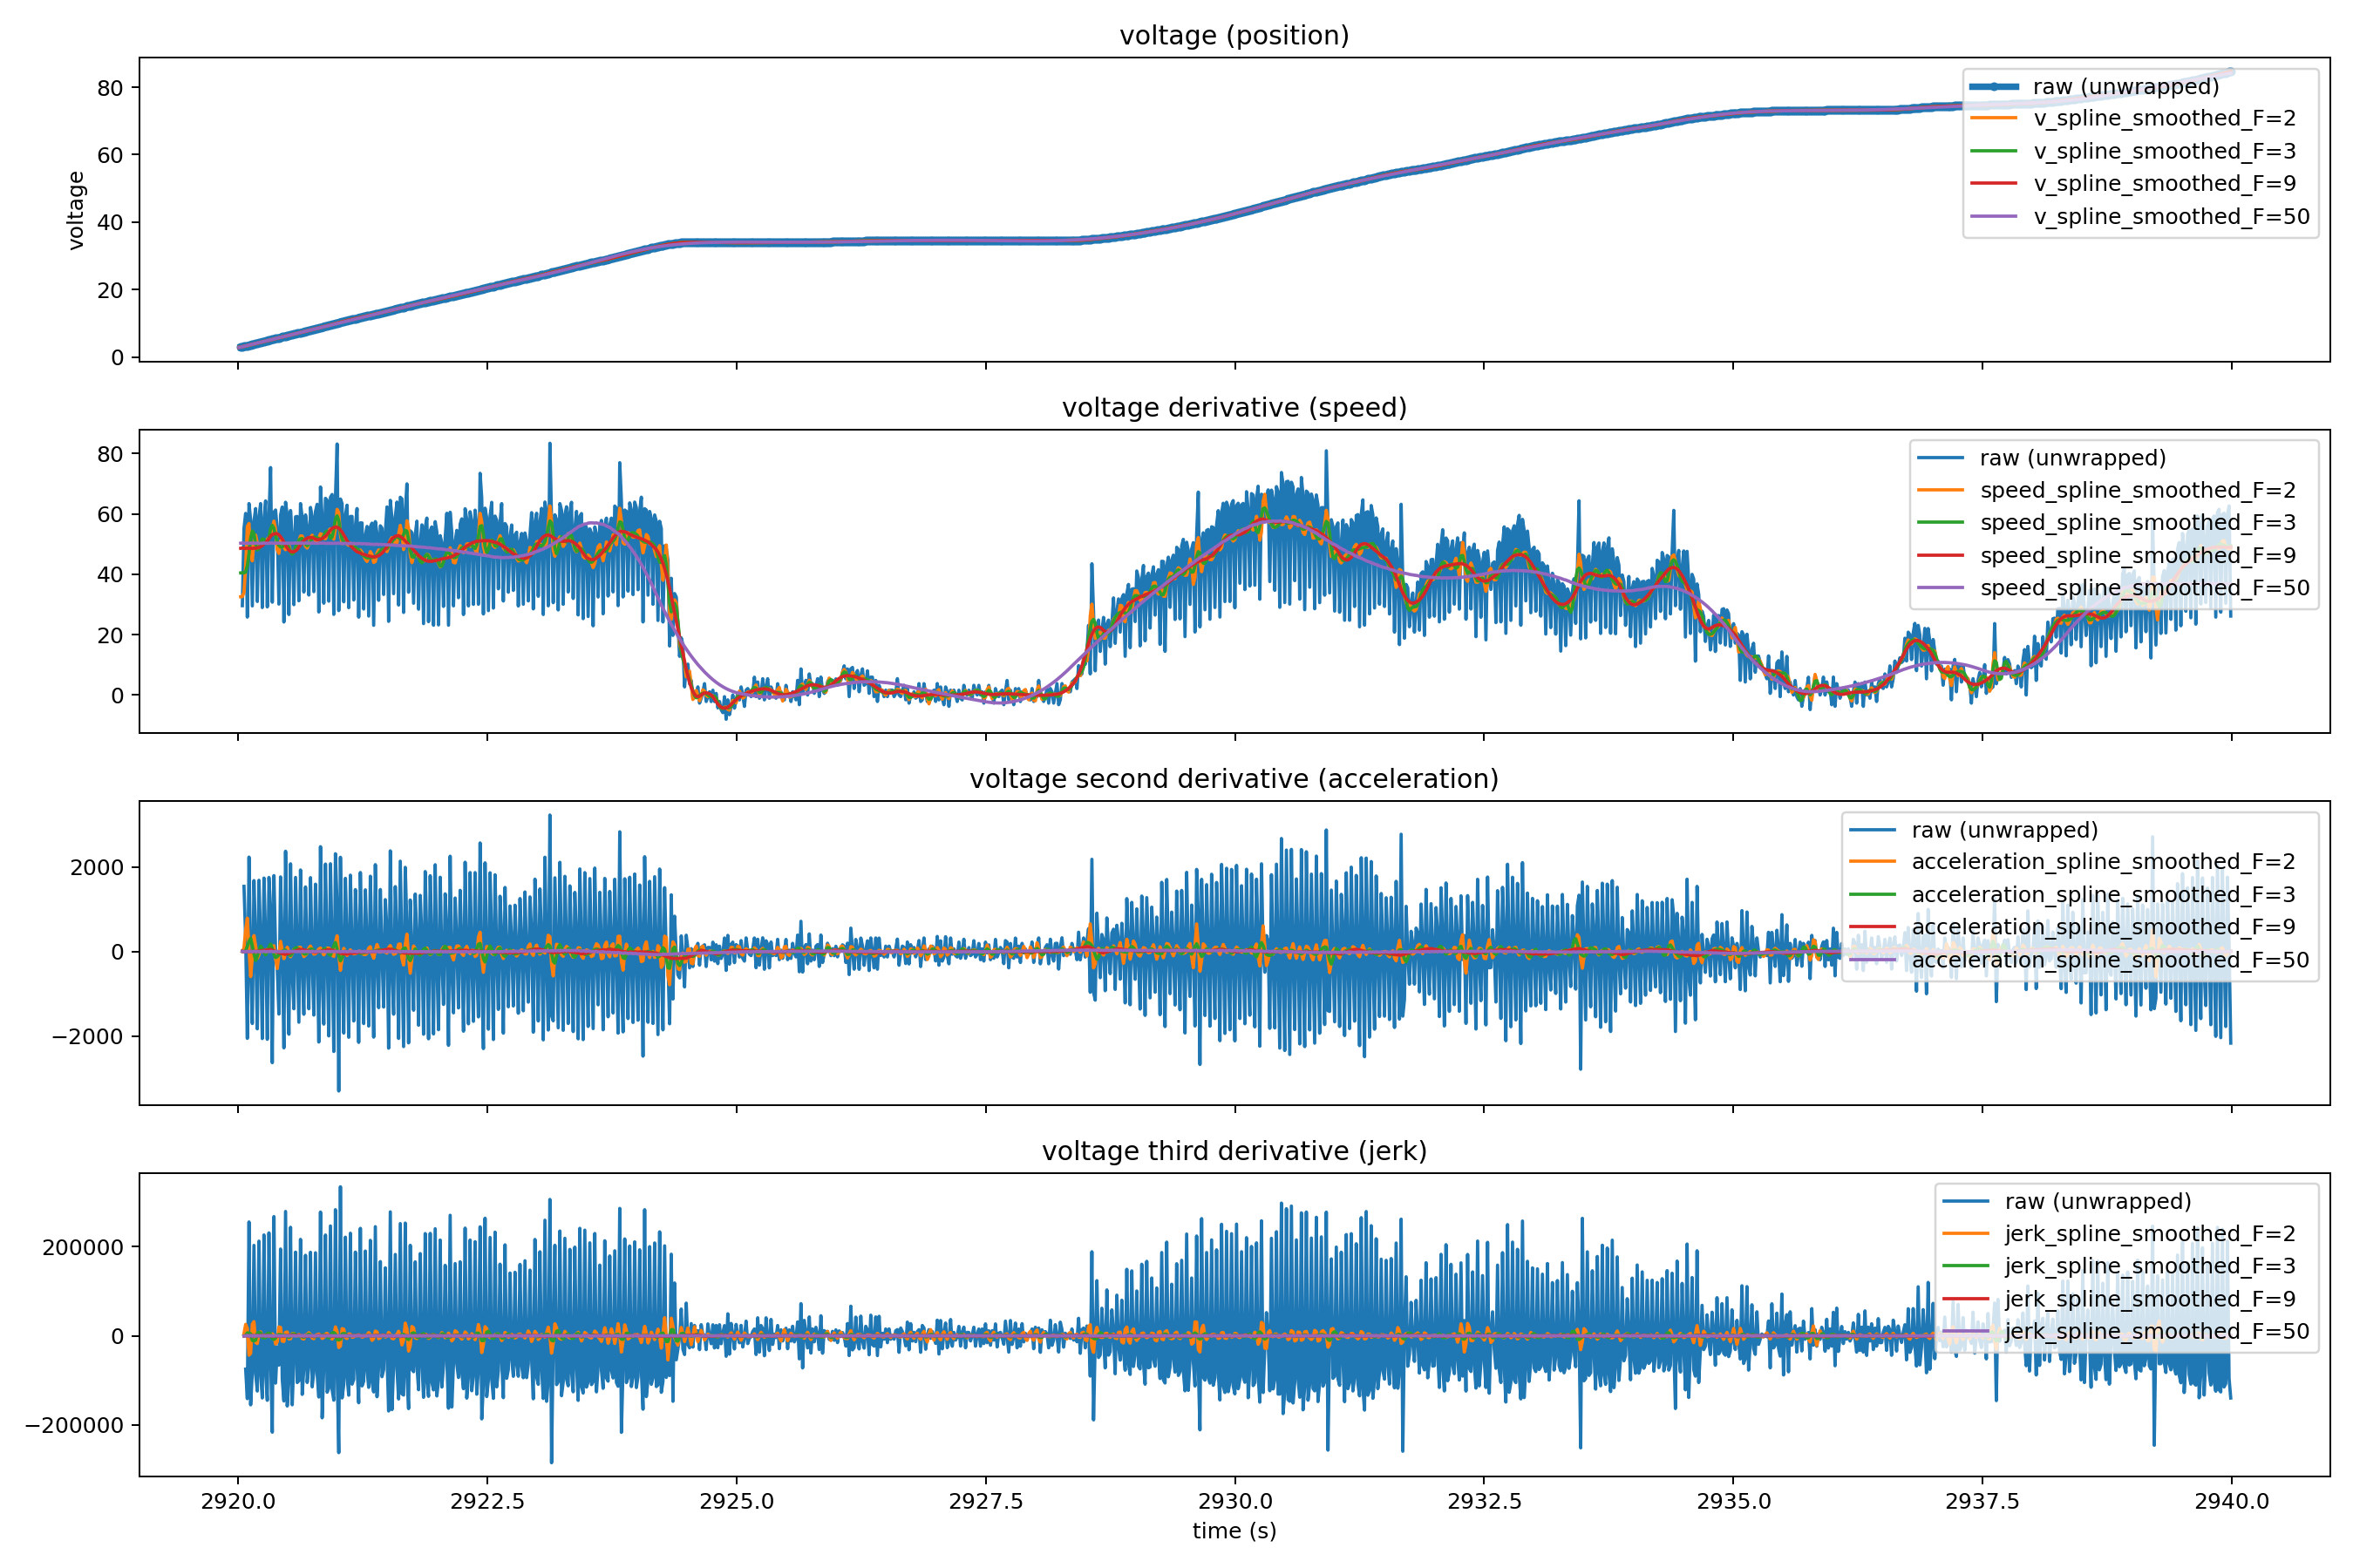

In [443]:
fig,ax=plt.subplots(4,1,figsize=(15,10),sharex=True)

ax[0].plot(
    df_sample['time'],
    df_sample['v_sig_unwrapped'],
    marker='.',
    linewidth=3
)

legend = ['raw (unwrapped)']

for n_knot_factor in n_knot_factors:
    ax[0].plot(
        df_sample['time'],
        df_sample['v_spline_smoothed_F={}'.format(n_knot_factor)],
    )
    legend.append('v_spline_smoothed_F={}'.format(n_knot_factor))

ax[0].set_ylabel('voltage')
ax[0].legend(legend,loc='upper right')

ax[0].set_title('voltage (position)')


ax[1].set_title('voltage derivative (speed)')


ax[1].plot(
    df_sample['time'],
    df_sample['speed_raw']
)

legend = ['raw (unwrapped)']
for n_knot_factor in n_knot_factors:
    ax[1].plot(
        df_sample['time'],
        df_sample['speed_spline_smoothed_F={}'.format(n_knot_factor)],
    )
    legend.append('speed_spline_smoothed_F={}'.format(n_knot_factor))
ax[1].legend(legend,loc='upper right')

ax[2].plot(
    df_sample['time'],
    df_sample['acceleration_raw']
)

legend = ['raw (unwrapped)']
for n_knot_factor in n_knot_factors:
    ax[2].plot(
        df_sample['time'],
        df_sample['acceleration_spline_smoothed_F={}'.format(n_knot_factor)],
    )
    legend.append('acceleration_spline_smoothed_F={}'.format(n_knot_factor))
ax[2].legend(legend,loc='upper right')
ax[2].set_title('voltage second derivative (acceleration)')


ax[3].plot(
    df_sample['time'],
    df_sample['jerk_raw']
)

legend = ['raw (unwrapped)']
for n_knot_factor in n_knot_factors:
    ax[3].plot(
        df_sample['time'],
        df_sample['jerk_spline_smoothed_F={}'.format(n_knot_factor)],
    )
    legend.append('jerk_spline_smoothed_F={}'.format(n_knot_factor))
ax[3].legend(legend,loc='upper right')
ax[3].set_title('voltage third derivative (jerk)')
ax[3].set_xlabel('time (s)')

fig.tight_layout()

In [445]:
def mean_squared_jerk(df_in,voltage_col):
    df = df_in.copy()
    df['speed'] = calculate_speed(df, voltage_column=voltage_col)
    df['acceleration'] = calculate_derivative(df, 'speed')
    df['jerk'] = calculate_derivative(df, 'acceleration')
    return np.mean(df['jerk']**2)

In [446]:
def total_jerk(df_in,voltage_col='v_spline_smoothed'):
    df = df_in.copy()
    df['speed'] = calculate_speed(df, voltage_column=voltage_col)
    df['acceleration'] = calculate_derivative(df, 'speed')
    df['jerk'] = calculate_derivative(df, 'acceleration')
    return np.sum(df['jerk'].abs())

In [447]:
def jerk_integral(df_in,voltage_col='v_spline_smoothed'):
    df = df_in.copy()
    df['speed'] = calculate_speed(df, voltage_column=voltage_col)
    df['acceleration'] = calculate_derivative(df, 'speed')
    df['jerk'] = calculate_derivative(df, 'acceleration')
    return np.sum(df['jerk'].abs())

In [448]:
def mean_squared_error(df_in,col_1,col_2):
    return np.mean((df_in[col_1] - df_in[col_2])**2)

In [450]:
optimization_results = []
df_temp = df_sample.copy()
for i in range(1,100):
    n_knots = len(df_sample)/i
    df_temp['v_spline_smoothed'] = spline_regression(df_temp, col_to_smooth='v_sig_unwrapped', n_knots=n_knots)
    df_temp['speed_spline_smoothed'] = calculate_speed(df_temp, voltage_column='v_spline_smoothed')
    
    optimization_results.append({
        'n_knot_factor':i,
        'n_knots':n_knots,
        'mean_squared_jerk':mean_squared_jerk(df_temp,voltage_col='v_spline_smoothed'),
        'total_jerk':total_jerk(df_temp,voltage_col='v_spline_smoothed'),
        'mean_squared_error':mean_squared_error(df_temp,'speed_spline_smoothed','speed_raw')
    })
optimization_results = pd.DataFrame(optimization_results)

In [451]:
def optimization_function(row,k1,k2):
    return k1*row['total_jerk'] + k2*row['mean_squared_error']

In [460]:
optimization_results['j'] = optimization_results.apply(optimization_function, axis=1, k1=0.00001,k2=1)
optimization_results

,n_knot_factor,n_knots,mean_squared_jerk,total_jerk,mean_squared_error,j
0,1,1199.000000,1.259039e+10,1.043355e+08,0.525013,1043.880052
1,2,599.500000,7.988335e+07,6.914475e+06,104.596032,173.740785
2,3,399.666667,9.031271e+06,2.500471e+06,107.278105,132.282814
3,4,299.750000,2.351251e+06,1.278934e+06,107.918187,120.707531
4,5,239.800000,9.322225e+05,8.508301e+05,108.270265,116.778566
5,6,199.833333,5.517863e+05,6.424210e+05,108.458963,114.883172
6,7,171.285714,3.829718e+05,5.514875e+05,108.597662,114.112537
7,8,149.875000,2.731754e+05,4.844922e+05,108.877998,113.722920
8,9,133.222222,2.161551e+05,4.239613e+05,109.107824,113.347437
9,10,119.900000,1.894980e+05,3.986419e+05,109.173825,113.160244


<IPython.core.display.Javascript object>


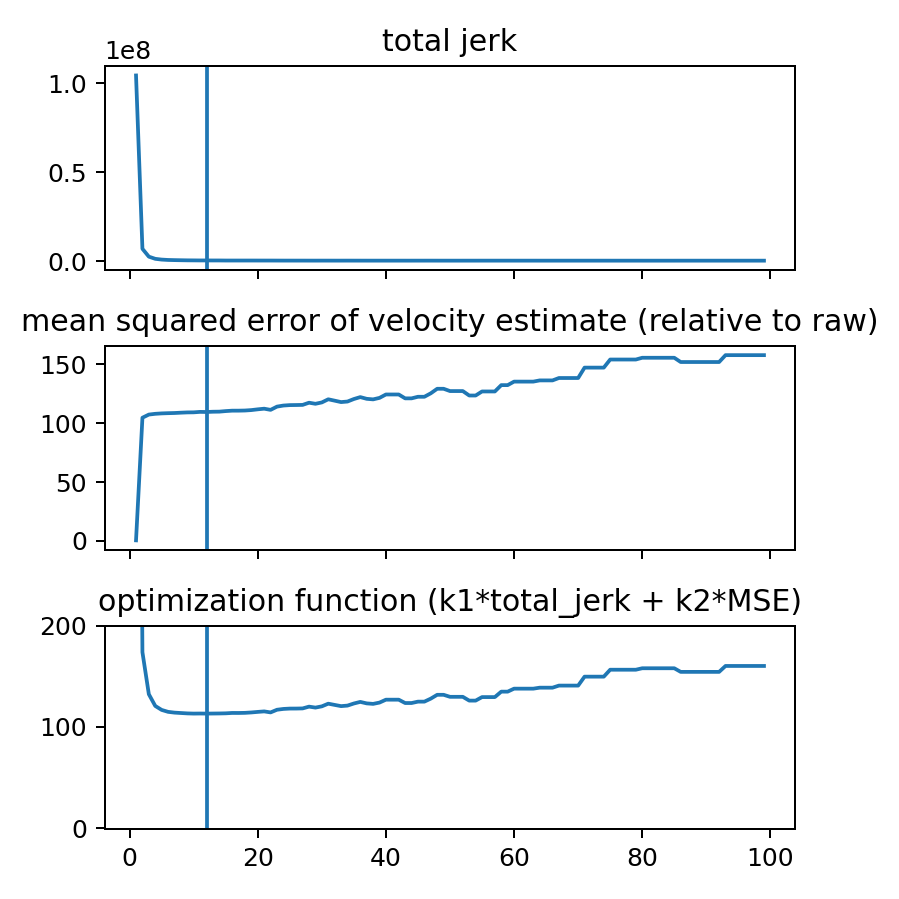

the optimal n_knot factor is 12.0


In [461]:
fig,ax=plt.subplots(3,1,sharex=True,figsize=(5,5))
ax[0].plot(optimization_results['n_knot_factor'],optimization_results['total_jerk'])
ax[1].plot(optimization_results['n_knot_factor'],optimization_results['mean_squared_error'])
ax[2].plot(optimization_results['n_knot_factor'],optimization_results['j'])
ax[2].set_ylim(-1,200)

optimal_index = optimization_results['j'].argmin()
for i in range(3):
    ax[i].axvline(optimization_results.iloc[optimal_index]['n_knot_factor'])
    
ax[0].set_title('total jerk')
ax[1].set_title('mean squared error of velocity estimate (relative to raw)')
ax[2].set_title('optimization function (k1*total_jerk + k2*MSE)')
fig.tight_layout()

print('the optimal n_knot factor is {}'.format(optimization_results.iloc[optimal_index]['n_knot_factor']))


In [421]:
optimization_results['j'].argmin()

9

In [289]:
time_column = 'time'
df = dft
dt1 = df[time_column].diff().shift(1) # deltaa time at each step, shifted to realign
dt2 = df[time_column].diff().shift(-1) # deltaa time at each step, shifted to realignn

0      NaN
1      NaN
2     0.50
3     0.50
4     0.50
5     0.50
6     1.00
7     1.00
8     0.50
9     0.25
10    0.25
11    0.10
12    0.20
13    0.10
14    0.10
15    0.50
16    1.00
17    1.00
18    1.00
Name: time, dtype: float64

In [296]:
len(np.nanmean((dt1,dt2),axis=0))

19

In [297]:
len(dt1)

19

In [298]:
def calculate_derivative(df,column_to_differentiate,time_column='time',shift=0):
    dy = df[column_to_differentiate].diff() # delta at each step

    dt = df[time_column].diff().shift(shift) # deltaa time at each step, shifted to realign
    dt1 = df[time_column].diff().shift(1) # deltaa time at each step, shifted to realign
    dt2 = df[time_column].diff().shift(-1) # deltaa time at each step, shifted to realign
    dt = np.nanmean((dt1,dt2),axis=0)
    
    derivative = dy/dt
    
    return derivative

In [299]:
t = np.array([0,0.5,1,1.5,2,3,4,4.5,4.75,5,5.1,5.3,5.4,5.5,6,7,8,9,10])
dft = pd.DataFrame({
    'time':t,
    'y':2*t**2,
    'y_p':4*t,
    'y_pp':4*np.ones_like(t),
})


<IPython.core.display.Javascript object>


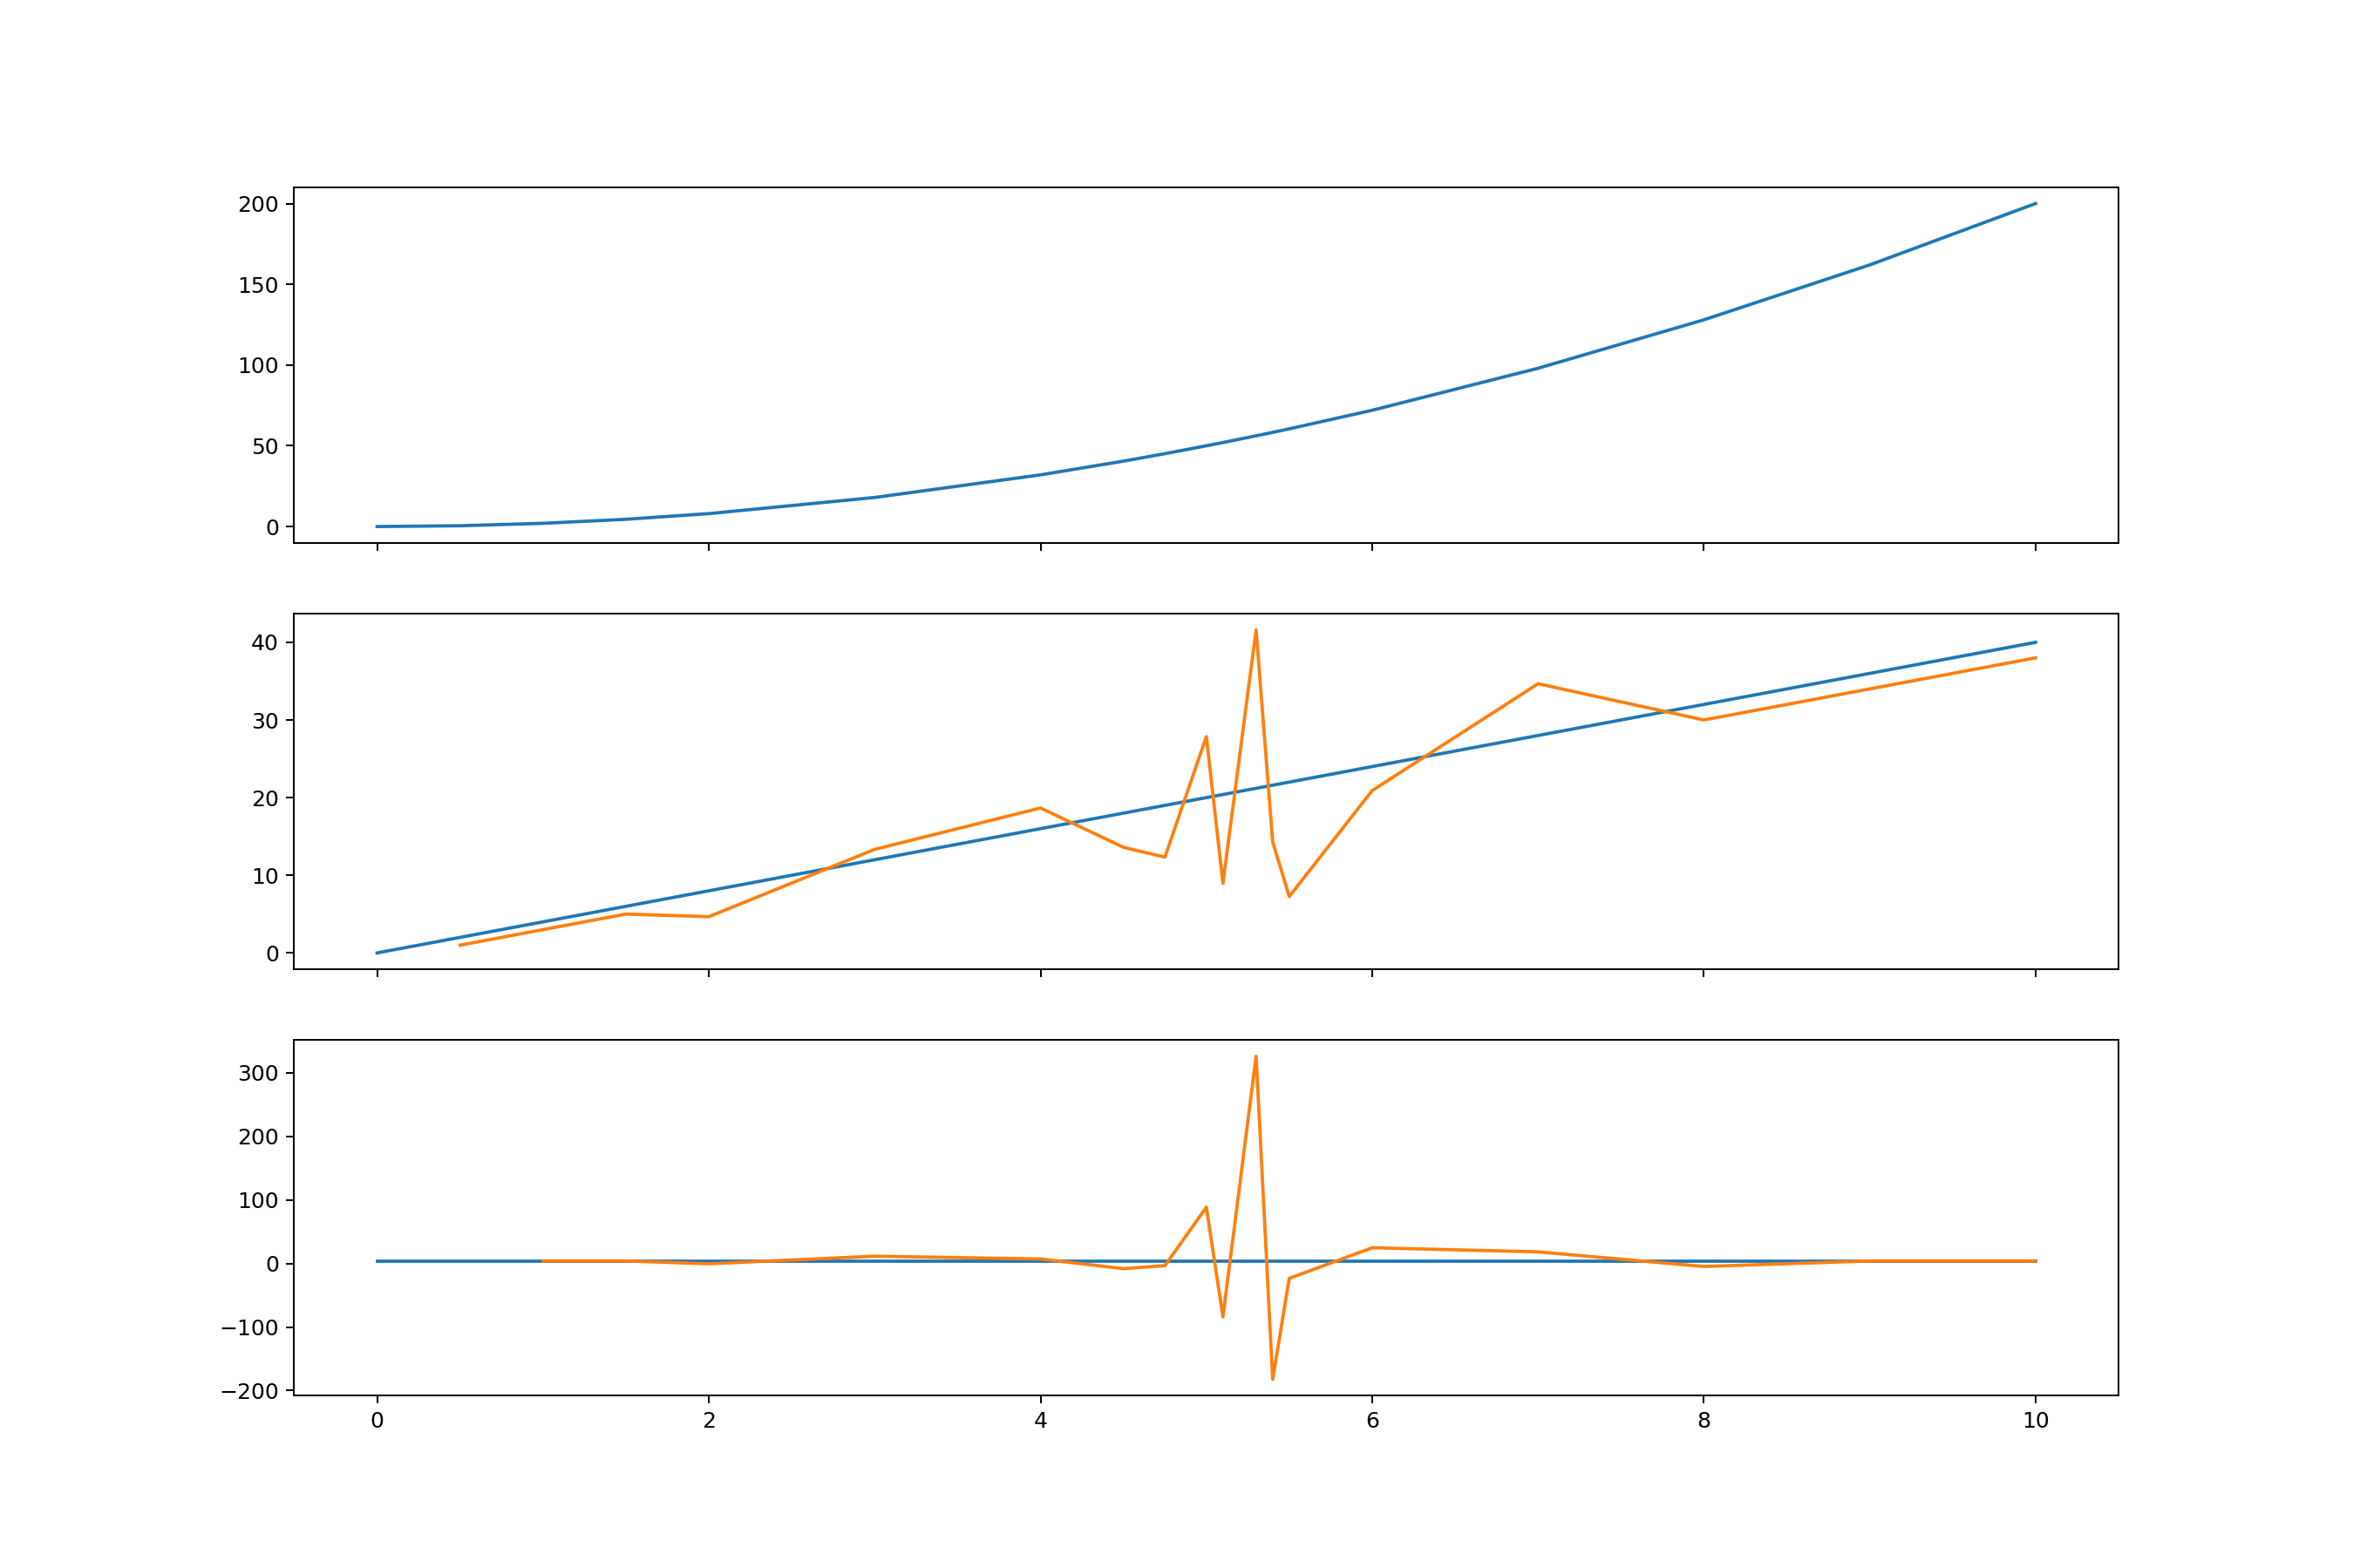

In [300]:
dft['y_prime'] = calculate_derivative(dft, 'y', shift=0)
dft['y_primeprime'] = calculate_derivative(dft, 'y_prime', shift=0)

fig,ax=plt.subplots(3,1,figsize=(15,10),sharex=True)
ax[0].plot(dft['time'],dft['y'])
ax[1].plot(dft['time'],dft['y_p'])
ax[1].plot(dft['time'],dft['y_prime'])

ax[1].plot(
    numpy.gradient(
        dft['y'],
        
)

ax[2].plot(dft['time'],dft['y_pp'])
ax[2].plot(dft['time'],dft['y_primeprime'])

In [265]:
dft['y'].diff().diff()/dft['time'].diff().diff()

0              NaN
1              NaN
2              inf
3              inf
4              inf
5     1.300000e+01
6              inf
7     1.100000e+01
8     1.550000e+01
9              inf
10    1.903333e+01
11    2.140000e+01
12    2.020000e+01
13   -4.503600e+13
14    2.330000e+01
15    2.900000e+01
16             inf
17             inf
18             inf
dtype: float64

In [267]:
dft['time'].diff()

0      NaN
1     0.50
2     0.50
3     0.50
4     0.50
5     1.00
6     1.00
7     0.50
8     0.25
9     0.25
10    0.10
11    0.20
12    0.10
13    0.10
14    0.50
15    1.00
16    1.00
17    1.00
18    1.00
Name: time, dtype: float64